# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [2]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

print(rncp.head())

   Categorie                                text_certifications
0          1  Responsable de chantiers de bûcheronnage manue...
1          1  Responsable de chantiers de bûcheronnage manue...
2          1                                 Travaux forestiers
3          1                                              Forêt
4          1                                              Forêt


In [3]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [4]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [5]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [6]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
texts_reduced = texts[0::k]
labels_reduced = labels[0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 9432


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [7]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(texts_reduced,labels_reduced,test_size=0.2,random_state=24)

In [8]:
print(train_texts[:10])

['Mention Systèmes automatisés, réseaux et informatique industrielle', 'Responsable de travaux bâtiment et travaux publics', "Ingénieur diplômé de l'Ecole Supérieure d'Ingénieurs Léonard de Vinci (ESILV)", 'Mention Biologie Cellulaire, Physiologie, Pathologies (BCPP), Spécialité Biologie, Physiopathologie, Pharmacologie du Cœur et de la Circulation (BioCœur)', 'Ingénieur diplômé de l’Ecole nationale supérieure de mécanique et des microtechniques', 'Industrie agro-alimentaire, alimentation option management des risques industriels', "Ingénieur du Génie Rural, des Eaux et des Forêts, diplômé de l'Ecole nationale du génie rural, des eaux et des forêts (ENGREF)", "Institut supérieur de l'électronique et du numérique-Brest (ISEN-Brest) en partenariat avec l'ITII Bretagne, spécialité Électronique et Informatique Industrielle", 'Sciences humaines et sociales, mention Anthropologie', 'Sciences, Technologies et Environnement Marin (STEM) Spécialité « Biodiversité et Biomolécules Marines » (BIOM

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [9]:
# Imports
import nltk
from nltk.tokenize import word_tokenize
from nltk import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
import string

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase        
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """ 

    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    text = re.sub("l'|d'","",text)
    REMOVE_PUNCT = re.compile("[.;:!\'?,\"()\[\]’«»]")
    text = REMOVE_PUNCT.sub(" ", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)
    
    tokens = text.split()
    tokens = [t for t in tokens if t not in nltk.corpus.stopwords.words('french')]
            
    return tokens

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [11]:
def get_vocab(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    vocabulary = {}
    i = 0
    for text in texts:
        words = clean_and_tokenize(text)
        for w in words:
            if w not in vocabulary:
                vocabulary[w] = i
                i += 1
    return vocabulary

In [12]:
voc = get_vocab(train_texts)

In [13]:
print(voc)

{'mention': 0, 'systèmes': 1, 'automatisés': 2, 'réseaux': 3, 'informatique': 4, 'industrielle': 5, 'responsable': 6, 'travaux': 7, 'bâtiment': 8, 'publics': 9, 'ingénieur': 10, 'diplômé': 11, 'ecole': 12, 'supérieure': 13, 'ingénieurs': 14, 'léonard': 15, 'vinci': 16, 'esilv': 17, 'biologie': 18, 'cellulaire': 19, 'physiologie': 20, 'pathologies': 21, 'bcpp': 22, 'spécialité': 23, 'physiopathologie': 24, 'pharmacologie': 25, 'cœur': 26, 'circulation': 27, 'biocœur': 28, 'nationale': 29, 'mécanique': 30, 'microtechniques': 31, 'industrie': 32, 'agro': 33, 'alimentaire': 34, 'alimentation': 35, 'option': 36, 'management': 37, 'risques': 38, 'industriels': 39, 'génie': 40, 'rural': 41, 'eaux': 42, 'forêts': 43, 'engref': 44, 'institut': 45, 'supérieur': 46, 'électronique': 47, 'numérique': 48, 'brest': 49, 'isen': 50, 'partenariat': 51, 'itii': 52, 'bretagne': 53, 'sciences': 54, 'humaines': 55, 'sociales': 56, 'anthropologie': 57, 'technologies': 58, 'environnement': 59, 'marin': 60, 's

In [14]:
print(len(voc))

3210


What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Answer: Considering we have around 8000 texts, it seems to me like any vocabulary size less than that is appropriate, this way we get a word for each texts on average. Some problems still remain, the vocabulary contains some words and their plural but solving the problem is hard since there are lots of exceptions in french about plural forms. One solution could be using stemming but after trying it for a bit it did more harm than good. </div>

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [15]:
vector = CountVectorizer(vocabulary=voc)
bow_train = vector.fit_transform(train_texts)
bow_test = vector.transform(test_texts)

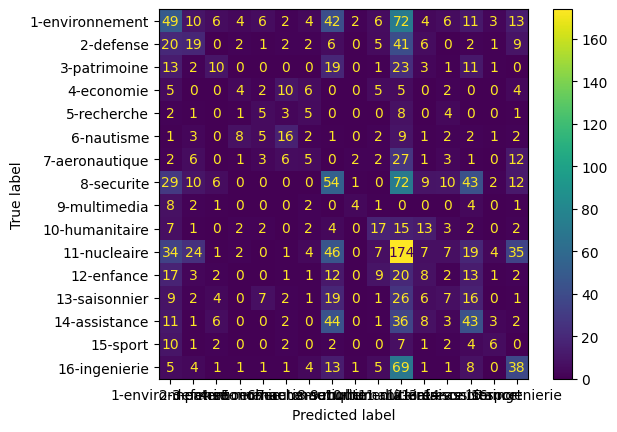

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
clf = LogisticRegression(max_iter=1000)
clf.fit(bow_train,train_labels)
y_pred = clf.predict(bow_test)

conf_mat = metrics.confusion_matrix(test_labels,y_pred)
conf_mat_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=Categories)
conf_mat_display.plot()
plt.show()


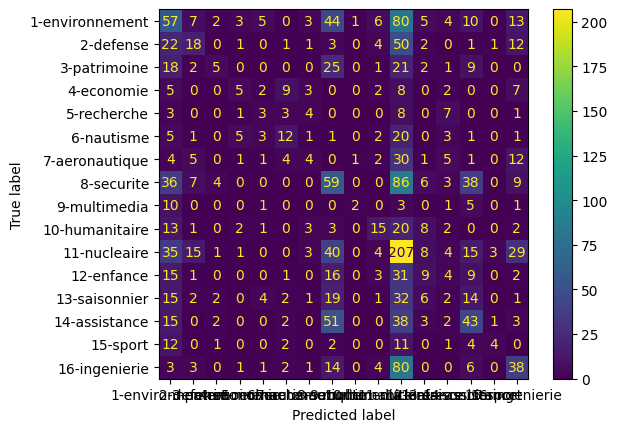

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvector = TfidfVectorizer(vocabulary=voc)
bow_train = tvector.fit_transform(train_texts)
bow_test = tvector.transform(test_texts)

clf = LogisticRegression(max_iter=1000)
clf.fit(bow_train,train_labels)
y_pred = clf.predict(bow_test)

conf_mat = metrics.confusion_matrix(test_labels,y_pred)
conf_mat_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=Categories)
conf_mat_display.plot()
plt.show()

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

In [18]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

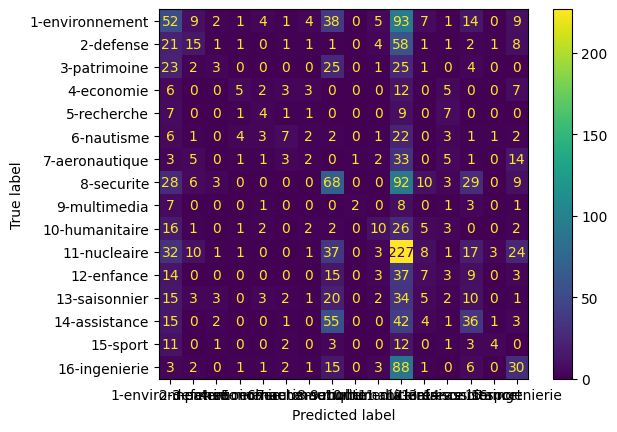

In [19]:
svd = TruncatedSVD(n_components=300,random_state=24)
bow_train_svd = svd.fit_transform(bow_train)
bow_test_svd = svd.transform(bow_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(bow_train_svd,train_labels)
y_pred = clf.predict(bow_test_svd)

conf_mat = metrics.confusion_matrix(test_labels,y_pred)
conf_mat_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=Categories)
conf_mat_display.plot()
plt.show()

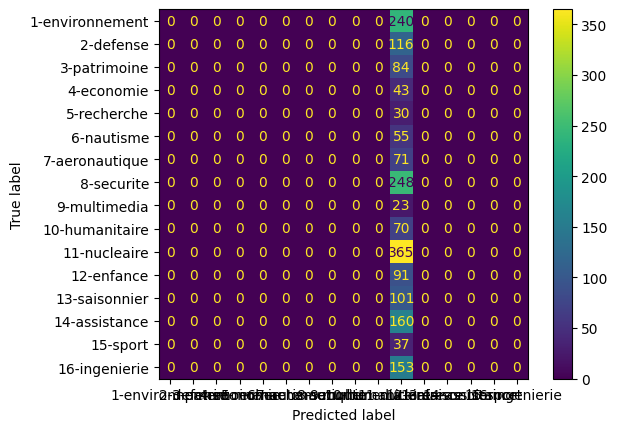

In [20]:
lda = LatentDirichletAllocation(n_components=300,random_state=24)
bow_train_lda = lda.fit_transform(bow_train)
bow_test_lda = lda.transform(bow_test)

clf = LogisticRegression(max_iter=1000)
clf.fit(bow_train_lda,train_labels)
y_pred = clf.predict(bow_test_lda)

conf_mat = metrics.confusion_matrix(test_labels,y_pred)
conf_mat_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=Categories)
conf_mat_display.plot()
plt.show()

<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

**Answer:** We could select a percentage of the variance that we want our reduced data to be able to explain and then search for the number of components necessary to reach this percentage by going through a loop.

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [21]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        sent = sent.copy()
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = [vocabulary[w] for w in sent if w in vocabulary.keys()]
        indexes = np.unique(sent_idx, return_index=True)[1]
        sent_idx = [sent_idx[index] for index in sorted(indexes)]
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1) # This adds an Unkown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[i-window:i]                
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j] and M[j,i]:      
            for j, ctx_idx in enumerate(l_ctx_idx):
                M[i,j] += 1/(abs(idx-ctx_idx))
                M[j,i] += 1/(abs(idx-ctx_idx))  
    return M  

<div class='alert alert-block alert-info'>
            Code:</div>

In [22]:
clean_train_texts = [clean_and_tokenize(t) for t in train_texts]

In [23]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension
com = co_occurence_matrix(clean_train_texts,voc)

In [24]:
word_embeddings = TruncatedSVD(n_components=300,random_state=24).fit_transform(com)

In [25]:
print(word_embeddings.shape)

(3210, 300)


<div class='alert alert-block alert-info'>
            Code:</div>

In [55]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        indexes = np.unique([vocabulary[w] for w in text if w in vocabulary.keys()]) # Indexes of words in the sentence obtained thanks to the vocabulary
        if len(indexes)>0:
            sentrep = np_func(embeddings[indexes],axis = 0) # Embeddings of words in the sentence, aggregated thanks to the function
        else:
            sentrep = np.zeros(embeddings.shape[1])
        representations.append(sentrep)
    representations = np.array(representations)    
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [27]:
clean_test_texts = [clean_and_tokenize(t) for t in test_texts]

In [28]:
# Obtain document representations, apply the classifier
train_rep = sentence_representations(clean_train_texts,voc,word_embeddings)
test_rep = sentence_representations(clean_test_texts,voc,word_embeddings)

In [29]:
print(train_rep.shape)
print(test_rep.shape)

(7545, 300)
(1887, 300)


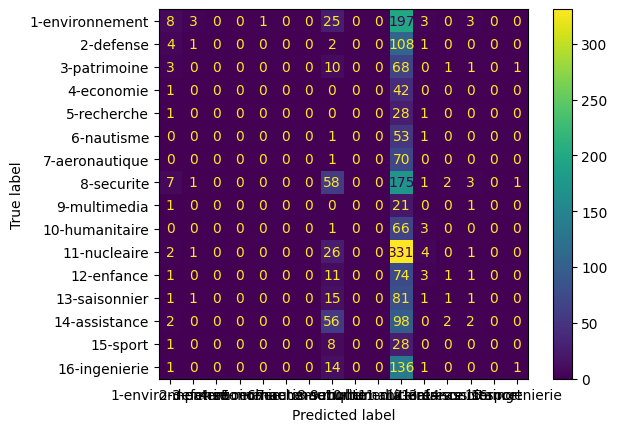

In [30]:
clf = LogisticRegression(max_iter=10000)
clf.fit(train_rep,train_labels)
y_pred = clf.predict(test_rep)

conf_mat = metrics.confusion_matrix(test_labels,y_pred)
conf_mat_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=Categories)
conf_mat_display.plot()
plt.show()

## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [31]:
from gensim.models import Word2Vec

In [32]:
def count(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    counts = {}
    for text in texts:
        words = clean_and_tokenize(text)
        for w in words:
            if w not in counts:
                counts[w] = 1
            else:
                counts[w] += 1
    return counts

In [33]:
word_counts = count(train_texts)

In [34]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts))
model.build_vocab_from_freq(word_counts)

<div class='alert alert-block alert-info'>
            Code:</div>

In [35]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.
preprocessed_corpus = clean_train_texts

In [36]:
model.train(preprocessed_corpus, total_examples=len(preprocessed_corpus), epochs=30, report_delay=1)

(1058547, 1728120)

In [37]:
print(model.wv.get_normed_vectors().shape)

(1052, 300)


Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [53]:
new_voc = {}
for i,w in enumerate(model.wv.index_to_key):
    new_voc[w] = i
print(new_voc)

{'spécialité': 0, 'mention': 1, 'sciences': 2, 'santé': 3, 'ingénieur': 4, 'gestion': 5, 'technologies': 6, 'diplômé': 7, 'domaine': 8, 'droit': 9, 'management': 10, 'nationale': 11, 'master': 12, 'informatique': 13, 'systèmes': 14, 'génie': 15, 'environnement': 16, 'professionnelle': 17, 'université': 18, 'ecole': 19, 'métiers': 20, 'langues': 21, 'arts': 22, 'option': 23, 'développement': 24, 'humaines': 25, 'communication': 26, 'sociales': 27, 'finalité': 28, 'supérieure': 29, 'fiche': 30, 'institut': 31, 'ingénierie': 32, 'lettres': 33, 'polytechnique': 34, 'manager': 35, 'école': 36, 'recherche': 37, 'information': 38, 'responsable': 39, 'réseaux': 40, 'economie': 41, 'industrielle': 42, 'économie': 43, 'production': 44, 'mécanique': 45, 'sécurité': 46, 'national': 47, 'appliquées': 48, 'marketing': 49, 'matériaux': 50, 'diplôme': 51, 'technologie': 52, 'qualité': 53, 'chimie': 54, 'biologie': 55, 'licence': 56, 'physique': 57, 'chef': 58, 'projet': 59, 'commerce': 60, 'électroniq

In [58]:
train_rep = sentence_representations(preprocessed_corpus,new_voc,model.wv.get_normed_vectors())
test_rep = sentence_representations(clean_test_texts,new_voc,model.wv.get_normed_vectors())

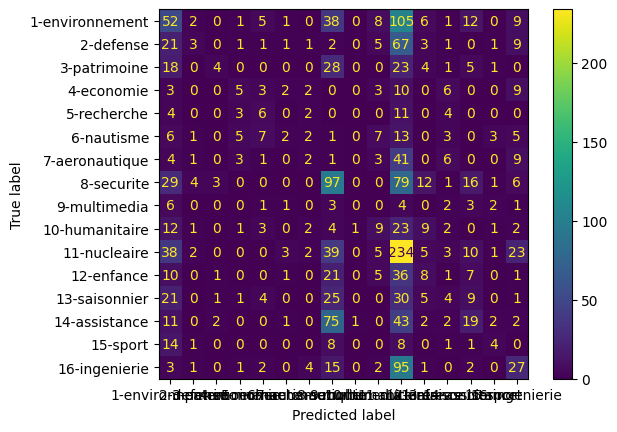

In [59]:
clf = LogisticRegression(max_iter=10000)
clf.fit(train_rep,train_labels)
y_pred = clf.predict(test_rep)

conf_mat = metrics.confusion_matrix(test_labels,y_pred)
conf_mat_display = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=Categories)
conf_mat_display.plot()
plt.show()

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 

This last classification was the best one we got so far but it is still mediocre. The main issue is the complete imbalance between each class, the class 'nucleaire' is so much bigger than the others that it ends up creating a lot of false positives which make the overall classification result pretty bad. In order to reach a better result we would need to reduce the size inequality between the classes which we can simply do some oversampling on our data which works very well on texts.